# Trabalho Prático Interação e Concorrência 21/22

* Tiago Carriço A91695
* Inês Presa A90355

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram, visualize_transition
from qiskit.tools import job_monitor
import matplotlib.pyplot as plt
import numpy as np

## Fórmula booleana utilizada

$f = (\neg v_1 \lor \neg v_2 \lor \neg v_3)\wedge (v_1 \lor \neg v_2 \lor v_3) \wedge (v_1 \lor v_2 \lor \neg v_3) \wedge (v_1 \lor \neg v_2 \lor \neg v_3) \wedge (\neg v_1 \lor v_2 \lor v_3) \wedge (v_1 \lor v_2 \lor v_3) \wedge (\neg v_1 \lor v_2 \lor \neg v_3)$

$$ c_1 = (\neg v_1 \lor \neg v_2 \lor \neg v_3)$$

$$ c_2 = (v_1 \lor \neg v_2 \lor v_3)$$

$$ c_3 = (v_1 \lor v_2 \lor \neg v_3)$$

$$ c_4 = (v_1 \lor \neg v_2 \lor \neg v_3)$$

$$ c_5 = (\neg v_1 \lor v_2 \lor v_3)$$

$$ c_6 = (\neg v_1 \lor \neg v_2 \lor v_3)$$

$$ c_7 = (v_1 \lor v_2 \lor v_3)$$

$v_1$ | $v_2$ | $v_3$ | $c_1$ | $c_2$ | $c_3$ | $c_4$ | $c_5$ | $c_6$ | $c_7$ | $f$
:---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- | :--
  0   |   0   |   0   |   1   |   1   |   1   |   1   |   1   |   1   |   0   |  0 
  0   |   0   |   1   |   1   |   1   |   0   |   1   |   1   |   1   |   1   |  0 
  0   |   1   |   0   |   1   |   0   |   1   |   1   |   1   |   1   |   1   |  0 
  0   |   1   |   1   |   1   |   1   |   1   |   0   |   1   |   1   |   1   |  0 
  1   |   0   |   0   |   1   |   1   |   1   |   1   |   0   |   1   |   1   |  0 
  1   |   0   |   1   |   1   |   1   |   1   |   1   |   1   |   1   |   1   |  1 
  1   |   1   |   0   |   1   |   1   |   1   |   1   |   1   |   0   |   1   |  0 
  1   |   1   |   1   |   0   |   1   |   1   |   1   |   1   |   1   |   1   |  0 

## Simulação

In [2]:
def execute_circuit(qc, shots=1024, decimal=False):
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = device.run(qc, shots=shots).result().get_counts()
    
    if decimal:
        counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
    else:
        counts = dict((a[::-1],b) for (a,b) in counts.items())

    return counts

In [3]:
def init(flips):
    qr = QuantumRegister(3)
    ancilla = QuantumRegister(len(flips) + 1)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr, ancilla, cr)

    qc.h(qr)
    qc.x(ancilla)
    qc.h(ancilla)
    qc.barrier()
    return qc, qr, ancilla, cr

In [4]:
def diffusion_operator(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)
    
    qc.h(qr)
    qc.x(qr)
    qc.h(qr[-1])
    # controlos sao todos menos o ultimo qubit e o target é o ultimo
    qc.mcx(qr[:-1],qr[-1])
    qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)

    qc.barrier()
    return qc 

In [5]:
def oracle(qr, ancilla, flips):
    qc = QuantumCircuit(qr, ancilla)
    clauses = len(flips)

    for k, flip in enumerate(flips):
        for i in range(3):
            if not flip[i]:
                qc.x(i)

        qc.mcx(qr, ancilla[k])
        qc.x(ancilla[k])

        for i in range(3):
            if not flip[i]:
                qc.x(i)

        qc.barrier()
    qc.mcx(ancilla[:-1],ancilla[-1])
    qc.barrier()
    return qc

In [6]:
def grover(qc, qr, ancilla, oracle):
    elements = 2**3

    iterations = int(np.floor(np.pi/4 * np.sqrt(elements)))

    for j in range(iterations):
        qc = qc.compose(oracle(qr, ancilla, flips))
        qc = qc.compose(diffusion_operator(qr, ancilla))
    return qc

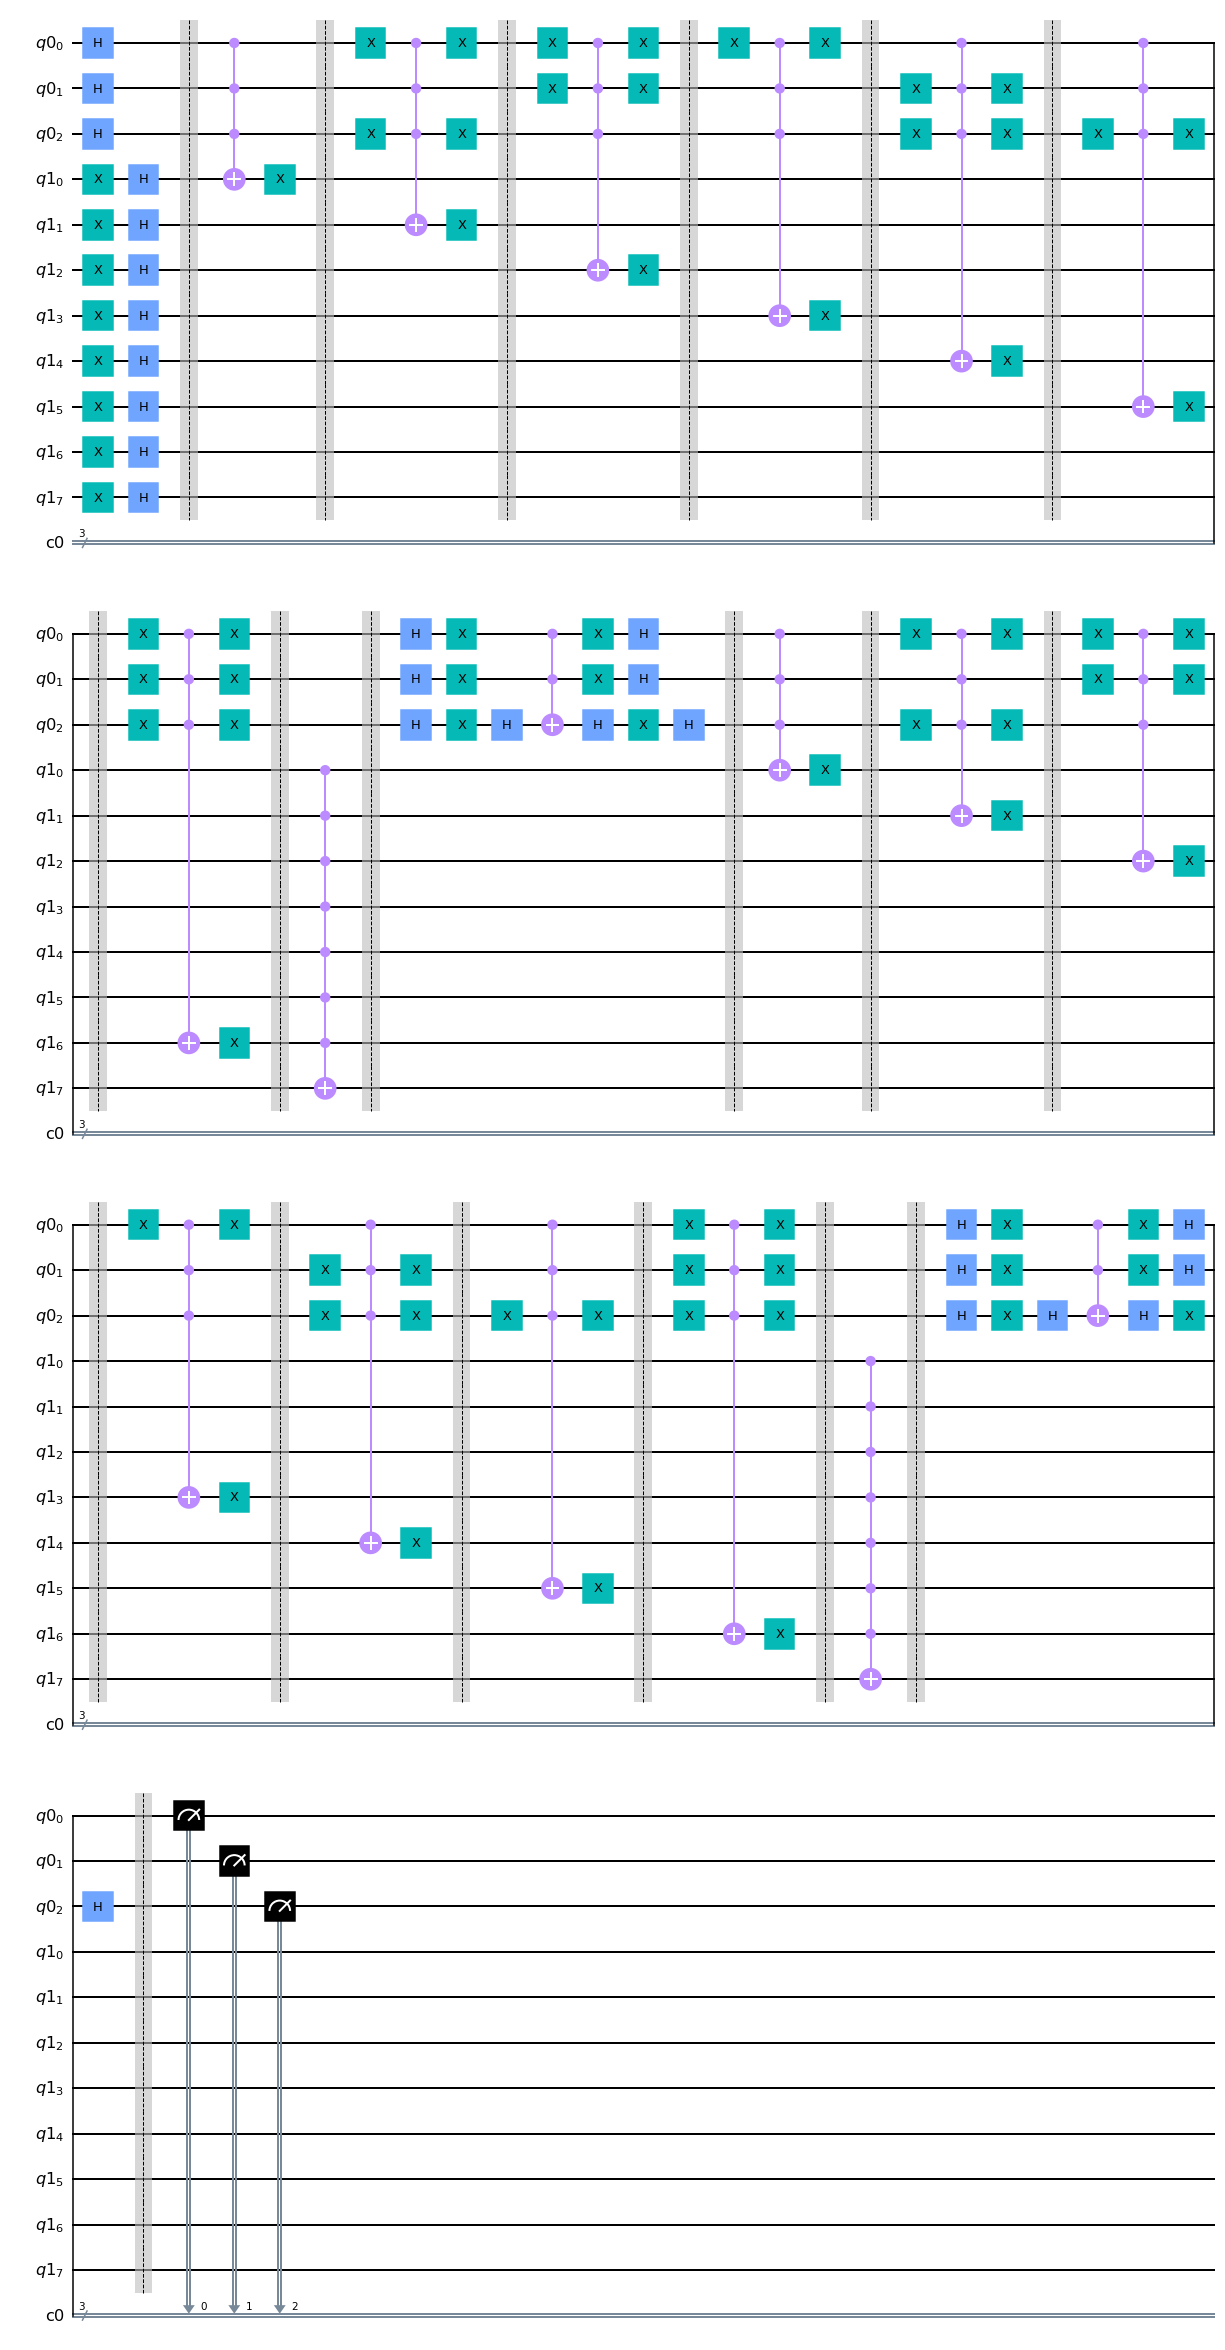

In [7]:
flips = [[True, True, True],
         [False, True, False],
         [False, False, True],
         [False, True, True],
         [True, False, False],
         [True, True, False],
         [False, False, False]]

qc, qr, ancilla, cr = init(flips)
qc = grover(qc, qr, ancilla, oracle)
qc.measure(qr, cr)
qc.draw(output="mpl")

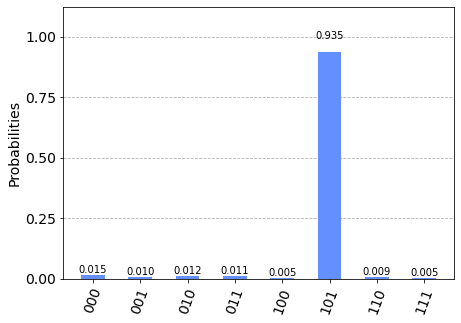

In [8]:
plot_histogram(execute_circuit(qc, 1024))

## IBM

In [ ]:
#IBMQ.active_account()
#IBMQ.save_account(ibm_token, overwrite=True)
IBMQ.load_account()

In [ ]:
provider = IBMQ.get_provider()
provider.backends(simulator=False, operational=True)

In [ ]:
backend = provider.get_backend("ibm_oslo")
backend.configuration().n_qubits

In [ ]:
job = execute(qc, backend)

In [ ]:
job_monitor(job)

In [ ]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts)